## **Imports**

In [2]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=9a73b950060577293fa999574bc108e5403607849fcb7b287a865e8b30dfabe2
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [3]:
import librosa   #for audio processing
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

## **Download Dataset**

In [4]:
!git clone https://github.com/getalp/ALFFA_PUBLIC.git

Cloning into 'ALFFA_PUBLIC'...
remote: Enumerating objects: 66024, done.
remote: Total 66024 (delta 0), reused 0 (delta 0), pack-reused 66024
Receiving objects: 100% (66024/66024), 6.54 GiB | 35.50 MiB/s, done.
Resolving deltas: 100% (12337/12337), done.
Checking out files: 100% (56925/56925), done.


## **Change Working Directory**

In [5]:
import os
os.chdir("ALFFA_PUBLIC/ASR/AMHARIC/")
len(os.listdir('data/train/wav/'))

10875

In [6]:
sample_rate = 44100

## **Load Audio Files**

In [7]:
def load_audio_files(path : str, sampling_rate : int, to_mono : bool) -> (dict, int):

  """
  Load the audio files and produce a dictionary mapping the audio filenames 
  to numpy arrays of the audio sampled at the given sample rate.

  Inputs: 
  path - a path to the directory that contains the audio files
  sample_rate - the sampling rate for the audio files
  to_mono - a boolean value denoting whether to convert signal to mono

  Returns:
  audio_files - audios - a dictionary mapping the wav file names to the sampled audio array
  max_length - the maximum length of a sampled audio array in our dataset
  """

  audio_files = {}
  max_length = 0
  i = 0
  for file in os.listdir(path):
    audio, rate= librosa.load(path+file, sr=sampling_rate, mono = to_mono)
    audio_files[file.split('.')[0]] = audio
    max_length = max(max_length,len(audio))
    i+=1
    if i%20 == 0:
      print('loaded',i,'audio files')
    if i == 100:
      break
  return audio_files, max_length

audio_files, maximum_length = load_audio_files('data/train/wav/', sample_rate, True)

loaded 20 audio files
loaded 40 audio files
loaded 60 audio files
loaded 80 audio files
loaded 100 audio files


In [8]:
print("The longest audio is",maximum_length/sample_rate, 'seconds long')

The longest audio is 16.256009070294784 seconds long


## **Load Transcripts**

In [9]:
def load_transcripts(filepath : str) -> dict:
  """
  Load the transcript file and produce a dictionary mapping the audio filenames 
  to the transcripts for those audio files.

  Inputs: 
  filepath - a path to the transcript file

  Returns:
  transcripts - a python dictionary mapping the wav file names to the transcripts
                of those audio files.
  """
  transcripts = {}
  with open (filepath, encoding="utf-8")as f:
    #print(f.readlines()[1])
    for line in f.readlines():
      
      text, filename = line.split("</s>")
      text, filename = text.strip()[3:], filename.strip()[1:-1]
      transcripts[filename] = text
    return transcripts

transcripts = load_transcripts("data/train/trsTrain.txt")

In [10]:
maximum_length

716890

**Sample audio along with transcript**

In [11]:
demo_audio = list(audio_files.keys())[1]

In [12]:
ipd.Audio(audio_files[demo_audio], rate=sample_rate)

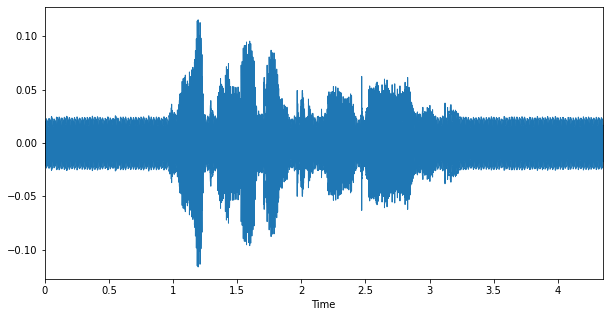

In [13]:
plt.figure(figsize=(10, 5))
librosa.display.waveplot(audio_files[demo_audio], sr=sample_rate)

In [14]:
transcripts[demo_audio]

' ህይወት ለማዳ ን ጥድፊያ ውን ተያያዙ ት'

 **Convert to Double Channel**

In [15]:
# def convert_to_double_channel(audios):
#   for name in audios:
#     if len(audios[name].shape) == 1:
#       audios[name] = np.array([audios[name],audios[name]])
#   return audios
# print(audio_files['tr_10027_tr097109'].shape)
# convert_to_double_channel(audio_files)
# print(audio_files['tr_10027_tr097109'].shape)

**Resize Audios For Double Channel**

In [16]:
# def resize_audios_double(audios,max_length):
#   for name in audios:
#     audios[name] = np.pad(audios[name], ((0,0),(0,max_length-audios[name].shape[1])), 'constant')
#   return audios

## **Resize Audios For Mono Channel**

In [17]:
def resize_audios_mono(audios : dict, max_length : int) -> dict:
  """
  Here we pad the sampled audio with zeros so tha all of the sampled audios 
  have equal length

  Inputs: 
  audios - a dictionary mapping the wav file names to the sampled audio array
  max_length - the maximum length of a sampled audio array in our dataset

  Returns:
  audios - a python dictionary mapping the wav file names to the padded
          audio samples
  """
  for name in audios:
    audios[name] = np.pad(audios[name], 
                          (0, max_length-len(audios[name])),
                          mode = 'constant')
  return audios

resize_audios_mono(audio_files, maximum_length)
print(audio_files[demo_audio].shape)

(716890,)


**Waveplot For Padded Audio**

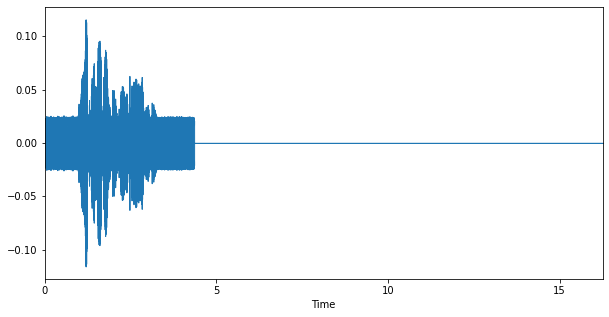

In [18]:
plt.figure(figsize=(10, 5))
librosa.display.waveplot(audio_files[demo_audio], sr= sample_rate)

**Sample Padded Audio**

In [19]:
ipd.Audio(audio_files[demo_audio], rate=sample_rate)

## **Augment Audios**

In [20]:
def augment_audio(audios : dict, sample_rate : int) -> dict:
  """
  Here we shift the wave by sample_rate/10 factor. This will move the wave to the 
  right by given factor along time axis. For achieving this I have used numpy’s 
  roll function to generate time shifting.

  Inputs: 
  audios - a dictionary mapping the wav file names to the sampled audio array
  sample_rate - the sample rate for the audio

  Returns:
  audios - a python dictionary mapping the wav file names to the augmented 
          audio samples
  """
  for name in audios:
    audios[name] = np.roll(audios[name], int(sample_rate/10))
  return audios

augment_audio(audio_files, sample_rate)[demo_audio].shape

(716890,)

**Extract Features**

In [21]:
def extract_features(audios : dict, sample_rate : int) -> dict:
  """
  The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of 
  features (usually about 10–20) which concisely describe the overall shape of a 
  spectral envelope. It models the characteristics of the human voice.
  We compute the Mel frequency cepstral coefficients for each audio file.

  Inputs: 
  audios - a dictionary mapping the wav file names to the sampled audio array
  sample_rate - the sample rate for the audio

  Returns:
  mfcc_features - a python dictionary mapping the wav file names to the mfcc 
                  coefficients of the sampled audio files
  """
  mfcc_features = {}
  for audio in audios:
    mfcc_features[audio] = librosa.feature.mfcc(audios[audio], sr=sample_rate)
  return mfcc_features

mfcc_features = extract_features(audio_files, sample_rate)

**Plot MFCCs**

(20, 1401)


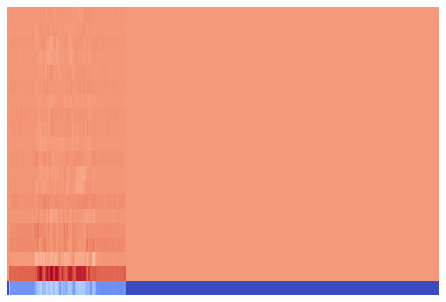

In [22]:
# MFCC
fig, ax = plt.subplots()
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
mfccs = mfcc_features[demo_audio]
print(mfccs.shape)
librosa.display.specshow(mfccs, sr=sample_rate, x_axis='time')

**Plot Mel Spectrogram**

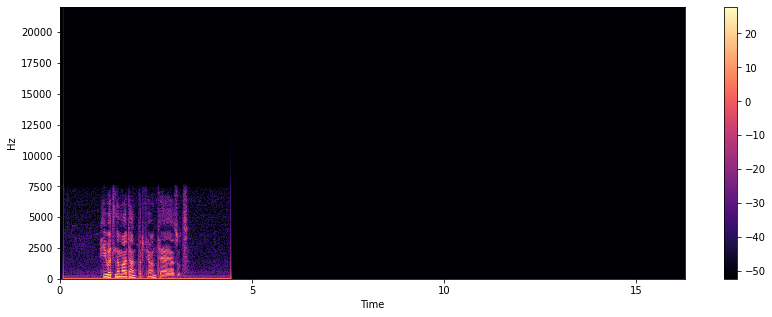

In [23]:
X = librosa.stft(audio_files[demo_audio])
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz')
plt.colorbar()

**Save MFCC Spectrogram Images**

In [24]:
!mkdir -p ../../../mfcc_train

def save_mfcc_spectrograms(mfccs: dict, sample_rate: int, path: str) -> int:
  """
  The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of 
  features (usually about 10–20) which concisely describe the overall shape of a 
  spectral envelope. It models the characteristics of the human voice.

  A Spectrogram captures the nature of the audio as an image by decomposing 
  it into the set of frequencies that are included in it.

  We plot the MFCC spectrogram for each audio file, and save the plots as .png 
  image files to the given target directory.

  Inputs: 
  mfccs - a python dictionary mapping the wav file names to the mfcc 
          coefficients of the sampled audio files
  sample_rate - the sampling rate for the audio
  path - the file path to the target directory

  Returns:
  0 if the spectrograms were saved successfully, and 
  1 if there was a FileNotFoundError
  """
  for audio in mfccs:
      fig, ax = plt.subplots()
      ax = plt.Axes(fig, [0., 0., 1., 1.])
      ax.set_axis_off()
      fig.add_axes(ax)
      librosa.display.specshow(mfccs[audio], sr= sample_rate, x_axis='time')
      try:
          plt.savefig(path+f'{audio}.png', dpi = 100)
      except FileNotFoundError:
          print(f'The directory {path} does not exist')
          return 1
      fig.clear()
  return 0

save_mfcc_spectrograms(mfcc_features, sample_rate, '../../../mfcc_train/')


0

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

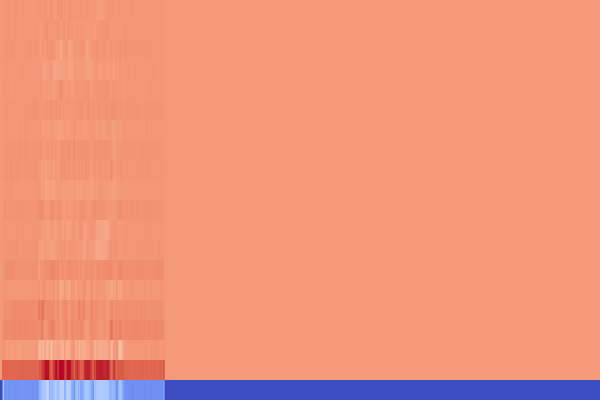

In [25]:
ipd.Image(filename=f'../../../mfcc_train/{demo_audio}.png')

In [26]:
len(audio_files)

100

**Fit Label Encoder with the Characters in the Transcripts**

In [31]:
from sklearn.preprocessing import LabelEncoder
def fit_label_encoder(transcripts : dict) -> LabelEncoder:
  """
  This function encodes the amharic characters in the given dictiionary of 
  transcripts into integers.

  Input:
  transcripts - a python dictionary mapping the wav file names to the transcripts
                of those audio files.
  Returns:
  encoder - an sklearn label encoder that has been fitted with all the characters 
  in the transcripts. 
  """
  characters = []
  for audio in transcripts:
    characters.extend(list(transcripts[audio]))
  encoder = LabelEncoder()
  encoder.fit_transform(characters)
  return encoder

char_encoder = fit_label_encoder(transcripts)
char_encoder.transform(list(transcripts[demo_audio]))

array([  0,   5, 149, 121,  76,   0,   7,  18, 154,   0,  93,   0, 181,
       156, 209, 147,   0, 126,  93,   0,  71, 147, 147, 129,   0,  76])

In [32]:
len(char_encoder.classes_)

222

**Encode the Characters in the Transcripts**

In [33]:
def encode_transcripts(transcripts : dict, encoder : LabelEncoder) -> dict:
  """
  This function takes an sklearn label encoder that has already been fitted with
  the amharic characters from the transcripts, along with the original transcript
  and encodes the transcripts for each audio using the given label encoder.

  Input:
  transcripts - a python dictionary mapping the wav file names to the transcripts
                of those audio files.
  encoder - an sklearn label encoder that has been fitted with all the characters 
            in the transcripts.

  Returns:
  transcripts_encoded - a python dictionary mapping the wav file names to the encoded transcripts
                        of those audio files.
  """
  transcripts_encoded = {}
  for audio in transcripts:
    transcripts_encoded[audio] = encoder.transform(list(transcripts[audio]))
  return transcripts_encoded

transcripts_encoded = encode_transcripts(transcripts, char_encoder)
len(transcripts_encoded), transcripts_encoded[demo_audio]

(10875, array([  0,   5, 149, 121,  76,   0,   7,  18, 154,   0,  93,   0, 181,
        156, 209, 147,   0, 126,  93,   0,  71, 147, 147, 129,   0,  76]))

## **Prepare Training Set**

In [34]:
from matplotlib import image
def load_spectrograms_with_transcripts(mfcc_features : dict, encoded_transcripts : dict, path : str):
  """
  Loads the spectrogram images as numpy arrays

  Inputs:
  mfcc_features - a python dictionary mapping the wav file names to the mfcc 
                  coefficients of the sampled audio files
  encoded_transcripts - a python dictionary mapping the wav file names to the 
                        encoded transcripts of those audio files.
  path - the path to the directory that contains the spectrogram images

  Returns:
  X_train - a numpy array containing the mfcc spectrograms of the sampled audio files
  y_train - a numpy array containing the encoded transcripts of the sampled audio files
            in the same order as they appear in X_train
  """
  X_train = []
  y_train = []
  for audio in mfcc_features:
    specgram = image.imread(path+f'{audio}.png')
    X_train.append(specgram)
    y_train.append(encoded_transcripts[audio])
  return np.array(X_train), y_train

X_train, y_train = load_spectrograms_with_transcripts(mfcc_features, 
                                                      transcripts_encoded,
                                                      '../../../mfcc_train/')
X_train.shape, len(y_train)

((100, 400, 600, 4), 100)

In [35]:
# def load_mfccs_with_transcripts(mfcc_features : dict, encoded_transcripts : dict):
#   """
#   Loads the mfcc arrays

#   Inputs:
#   mfcc_features - a python dictionary mapping the wav file names to the mfcc 
#                   coefficients of the sampled audio files
#   encoded_transcripts - a python dictionary mapping the wav file names to the 
#                         encoded transcripts of those audio files.

#   Returns:
#   X_train - a numpy array containing the mfcc spectrograms of the sampled audio files
#   y_train - a numpy array containing the encoded transcripts of the sampled audio files
#             in the same order as they appear in X_train
#   """
#   X_train = []
#   y_train = []
#   for audio in mfcc_features:
#     X_train.append(mfcc_features[audio])
#     y_train.append(encoded_transcripts[audio])
#   return np.array(X_train), y_train

# X_train, y_train = load_mfccs_with_transcripts(mfcc_features, 
#                                                       transcripts_encoded)

# X_train = X_train.reshape((100, 20, 1654,1))
# X_train.shape, len(y_train[0])

## **Deep Learning Model**

In [36]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, LSTM, MaxPooling2D, Bidirectional, Flatten

In [37]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


In [75]:
def equalize_transcript_dimension(y):
  """
  Make all transcripts have equal number of characters by padding the the short
  ones with spaces
  """
  max_len = max([len(trans) for trans in y])
  print(max_len)
  new_y = []
  for trans in y:
    new_y.append(np.pad(trans, 
                          (0, max_len-len(trans)),
                          mode = 'constant')[:20])
  return np.array(new_y)
y_train = equalize_transcript_dimension(y_train)
#y_train

100


In [113]:
input_img = layers.Input(
    shape=(400, 600, 4), name="image", dtype="float32"
)
labels = layers.Input(name="label", shape=(None,), dtype="float32")

# First conv block
x = layers.Conv2D(
    32,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
    name="Conv1",
)(input_img)
x = layers.MaxPooling2D((2, 2), name="pool1")(x)

# Second conv block
x = layers.Conv2D(
    64,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
    name="Conv2",
)(x)
x = layers.MaxPooling2D((2, 2), name="pool2")(x)
print(x.type_spec.shape)

# We have used two max pool with pool size and strides 2.
# Hence, downsampled feature maps are 4x smaller. The number of
# filters in the last layer is 64. Reshape accordingly before
# passing the output to the RNN part of the model

new_shape = (x.type_spec.shape[-3], x.type_spec.shape[-2]*x.type_spec.shape[-1])
x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
x = layers.Dense(64, activation="relu", name="dense1")(x)
x = layers.Dropout(0.2)(x)

# RNNs
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

# Output layer
x = layers.Dense(
    len(char_encoder.classes_) + 1, activation="softmax", name="dense2"
)(x)

# Add CTC layer for calculating CTC loss at each step
output = CTCLayer(name="ctc_loss")(labels, x)

# Define the model
model = keras.models.Model(
    inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
)
# Optimizer
opt = tf.keras.optimizers.Adam()
# Compile the model and return
model.compile(optimizer=opt)
model.summary()

(None, 100, 150, 64)
Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 400, 600, 4) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 400, 600, 32) 1184        image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 200, 300, 32) 0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 200, 300, 64) 18496       pool1[0][0]                      
__________________________________________________________________

In [101]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
print(X_train.shape, np.array(y_train).shape)
model.fit([X_train, np.array(y_train)], batch_size = 4, epochs = 100)

(100, 400, 600, 4) (100, 20)
Epoch 1/100
25/25 [==============================] - 1s 52ms/step - loss: 31.8252
Epoch 2/100
25/25 [==============================] - 1s 50ms/step - loss: 30.3073
Epoch 3/100
25/25 [==============================] - 1s 50ms/step - loss: 28.0136
Epoch 4/100
25/25 [==============================] - 1s 50ms/step - loss: 27.9428
Epoch 5/100
25/25 [==============================] - 1s 49ms/step - loss: 25.2785
Epoch 6/100
25/25 [==============================] - 1s 49ms/step - loss: 25.4207
Epoch 7/100
25/25 [==============================] - 1s 49ms/step - loss: 25.9665
Epoch 8/100
25/25 [==============================] - 1s 49ms/step - loss: 24.8227
Epoch 9/100
25/25 [==============================] - 1s 49ms/step - loss: 25.5511
Epoch 10/100
25/25 [==============================] - 1s 49ms/step - loss: 27.5476
Epoch 11/100
25/25 [==============================] - 1s 49ms/step - loss: 25.2904
Epoch 12/100
25/25 [==============================] - 1s 49ms/step 

In [111]:
predicted = model.predict([X_train[98:100],y_train[2:4]])
def decode(pred,encoder):
  """
  remove the blank character from the predictions and decode the integers back to
  amharic characters.
  """
  dec = []
  for a in pred:
    l = [np.argmax(b) for b in a]
    newl = []
    for i in range(len(l)):
      if l[i]!=222:
        newl.append(l[i])
    dec.append(''.join(encoder.inverse_transform(newl)))
  return dec
predicted_trans = decode(predicted, char_encoder)
real_trans = [''.join(char_encoder.inverse_transform(y)) for y in y_train]

print("pridicted:",predicted_trans[1])
print("actual:",real_trans[99])

pridicted:   አቶ     ገን    ቀማማሪሪ  ጊጊዜዜ    እያያ ጓ
actual:  እንደ ገና ተጨማሪ ጊዜ እያ ጓ
